In [1]:
# imports general modules, runs ipython magic commands
# change path in this notebook to point to repo locally
# n.b. sometimes need to run this cell twice to init the plotting paramters
%run ./setup_notebook.ipynb
%matplotlib inline

In [2]:
import json
with open('/home/jrowland/Documents/code/Vape/s2_position.json') as json_file:
    s1s2_border = json.load(json_file)
    
s1s2_border['J048']['27']

480

In [3]:
import scipy.io as spio

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    
    Stolen from some hero https://stackoverflow.com/a/8832212
    (Modified slightly so dont use dict as variable name)
    
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict_):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict_:
        if isinstance(dict_[key], spio.matlab.mio5_params.mat_struct):
            dict_[key] = _todict(dict_[key])
    return dict_        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict_ = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict_[strg] = _todict(elem)
        else:
            dict_[strg] = elem
    return dict_

In [4]:
import utils.utils_funcs as uf
import os
import cv2
import sys
from subsets_analysis import Subsets
import pickle
from gsheets_importer import path_finder
import math
import copy
from scipy import interpolate
from pathlib import Path
import scipy.io as sio
import h5py
import tifffile as tf
import popoff
from average_traces import AverageTraces
from Session import Session, SessionLite


/home/jrowland/Documents/code/pop-off/popoff/popoff/loadpaths.py


In [31]:
mice_dicts = [
    
{'mouse_id': 'J048', 'run_numbers': [27,28], 'runs': []},
# {'mouse_id': 'RL048', 'run_numbers': [23, 24, 25, 28, 29], 'runs': []},
# {'mouse_id': 'J063', 'run_numbers': [8,9,10,11,12,13,14], 'runs': []},

# {'mouse_id': 'J064', 'run_numbers': [10,11,12,13,14,15], 'runs': []},
{'mouse_id': 'J064', 'run_numbers': [10], 'runs': []},
# {'mouse_id': 'J065', 'run_numbers': [10,11,12,13,14,15], 'runs': []},
#{'mouse_id': 'RL070', 'run_numbers': [22,23,24,27,28,29], 'runs': []},
{'mouse_id': 'RL070', 'run_numbers': [28], 'runs': []},
# {'mouse_id': 'RL072', 'run_numbers': [19,20,21,24], 'runs': []},
    
]

In [34]:
for mouse_dict in mice_dicts:
    for run_number in mouse_dict['run_numbers']:
        
        pkl_path = os.path.join(path_to_vape, 'run_pkls', mouse_dict['mouse_id'], 
                                'run{}.pkl'.format(run_number))

        with open(pkl_path, 'rb') as f:
            run = pickle.load(f)
            
        mouse_dict['runs'].append(run)
    

#run = mice_dicts[0]['runs'][1]
run = mice_dicts[2]['runs'][0]

In [36]:
at = AverageTraces('dff')
session = at.sessions[0]
session

instance Mouse RL070, run 28 of Session class

In [9]:
sessions = at.sessions
sessions

{0: instance Mouse RL070, run 28 of Session class,
 1: instance Mouse RL070, run 29 of Session class,
 2: instance Mouse J048, run 27 of Session class,
 3: instance Mouse J048, run 28 of Session class,
 4: instance Mouse J048, run 29 of Session class,
 5: instance Mouse J048, run 30 of Session class,
 6: instance Mouse J048, run 32 of Session class,
 7: instance Mouse J064, run 10 of Session class,
 8: instance Mouse J064, run 11 of Session class,
 9: instance Mouse J064, run 14 of Session class,
 10: instance Mouse J063, run 8 of Session class,
 11: instance Mouse J063, run 9 of Session class,
 12: instance Mouse RL048, run 23 of Session class,
 13: instance Mouse RL048, run 24 of Session class,
 14: instance Mouse RL048, run 25 of Session class,
 15: instance Mouse RL048, run 28 of Session class,
 16: instance Mouse RL048, run 29 of Session class,
 17: instance Mouse J065, run 10 of Session class,
 18: instance Mouse J065, run 11 of Session class}

In [37]:
session.__dict__.keys()

dict_keys(['mouse', 'run_number', 'flu_flavour', 'pkl_path', 'pre_seconds', 'post_seconds', 'pre_gap_seconds', 'post_gap_seconds', 'verbose', 'filter_threshold', 'name', 'tstart_galvo', 'trial_start', 'galvo_ms', 'subsets', 'trial_subsets', 'n_stim_arr', 'outcome', 'outcome_arr', 'frequency', 'pre_frames', 'post_frames', 'art_gap_start', 'final_pre_gap_tp', 'art_gap_stop', 'filter_ps_array', 'filter_ps_time', 'behaviour_trials', 'pre_rew_trials', 'unfiltered_n_cells', 'filtered_neurons', 'n_cells', 'av_ypix', 'av_xpix', 'plane_number', 's1s2_border', 's2_bool', 's1_bool', 'decision', 'photostim', 'photostim_occ', 'autorewarded', 'unrewarded_hits', 'n_unique_stims', 'n_neurons', 'n_times', 'n_trials', 'n_unique_dec', 'occ_table', 'n_com_trials', 'is_target', 'nonnan_trials', 'frames_use'])

In [38]:
def pstation2qnap(path):
    
    ''' Converts a packerstation path to a qnap path '''
    
    # Path to qnap data folder
    qnap_data = os.path.expanduser('~/mnt/qnap/Data')
    
    # Part of the pstation path that is shared with the qnap path
    # Split with the seperator as path.join doesn't like leading
    # slashes.
    shared_path = path.split('Data'+ os.sep)[1]
    
    return os.path.join(qnap_data, shared_path)

In [39]:
blimp_path = pstation2qnap(run.blimp_path)

In [40]:
groups = {}
for folder in os.listdir(blimp_path):
    
    # Folders containing e.g. .mat files from groups have only numeric characters or _
    if all([np.logical_or(char.isdigit(), char=='_') for char in folder]):
        
        # Add the coordinates of stimulated cells in test trials
        group = {}
        
        mat_path = os.path.join(blimp_path, folder, 'matlab_input_parameters.mat')
        mat = loadmat(mat_path)
        
        group['x'] = mat['obj']['split_points']['X'] 
        group['y'] = mat['obj']['split_points']['Y'] 
        
        groups[folder] = group
        
# Add easy trials to groups dict. The mat in the loop should have an all_points field
group = {}
group['x'] = mat['obj']['all_points']['X'] 
group['y'] = mat['obj']['all_points']['Y'] 
groups['all'] = group

# Add a nogo key for easy hashing
group = {}
group['x'] = None
group['y'] = None
groups['nogo'] = group

In [41]:
trial_group = []
for info in run.trial_info:
    if info == 'all_cells_stimulated':
        trial_group.append('all')
    elif 'Nogo Trial' in info:
        trial_group.append('nogo')
    elif 'Go trial' in info:
        # Will probably break on windows but pathlib will not
        # parse this string for some reason and cannot split on os.sep
        trial_group.append(info.split(' ')[-1].split('\\')[-1])
    else:
        raise ValueError('Not sure what this trial is m8')
    
trial_group = np.array(trial_group)
    
assert len(trial_group) == len(Subsets(run).trial_subsets)
assert np.all(np.where(Subsets(run).trial_subsets==150)[0] == np.where(trial_group=='all')[0])
assert np.all(np.where(Subsets(run).trial_subsets==0)[0] == np.where(trial_group=='nogo')[0])

In [42]:
um_per_pixel = 1.35  # Correct-ish at 0.8x, check me
stim_radius = 17.5  #  Distance (um) from stim to be considered target
radius_px = stim_radius * um_per_pixel

In [53]:
def build_mask(group, single_plane):
    
    
    if single_plane:
        # I am using 512 even though actually 514. Shouldn't make a difference as using a
        # > 25 pixel radius for target. But check if need high precision
        mask = np.zeros((514, 1024))
    else:
        mask = np.zeros((1024,1024))

    for x,y in zip(group['x'], group['y']):

        if single_plane:
            # I think you just need to rescale x in the obfov condition. Be careful and check though
            scale_y = 1
        else:
            # I have rescaled by just multiplying coordinates by 2, go careful with this as not 
            # 100% sure it is correct
            scale_y = 2
            
        scale_x = 2
        
        mask = cv2.circle(mask, (int(scale_x*x), int(scale_y*y)) , radius=int(radius_px), color=1, thickness=-1)

    return mask.astype('bool')

In [54]:
def get_normalised_coords(stat):
    
    #cell_coords = np.array([stat[cell]['med'] for cell in range(len(stat))])
    cell_coords = np.array([[stat['ypix'], stat['xpix']] for stat in run.stat])
    
    try:
        global planes  # Fix me
        planes = np.array([stat[cell]['iplane'] for cell in range(len(stat))])
        cell_coords[planes==1, 1] = cell_coords[planes==1, 1] - 1024 
        cell_coords[planes==2, 0] = cell_coords[planes==2, 0] - 1024 
    except KeyError:  # Single plane
        pass
    
    return cell_coords
    return cell_coords.astype('int')

In [55]:
cell_coords = get_normalised_coords(run.stat)
min_coord = np.min([np.min(np.stack(cell_coord)) for cell_coord in cell_coords])
max_coord = np.max([np.max(np.stack(cell_coord)) for cell_coord in cell_coords])

assert min_coord > 0 and max_coord < 1024

cell_coords = cell_coords[session.filtered_neurons]
cell_coords.shape

(624, 2)

In [56]:
maxi = np.max([np.max(cell_coord[1]) for cell_coord in cell_coords])
maxi

1020

In [57]:
is_target = []
single_plane = True

for trial in trial_group:

    if trial == 'nogo':
        is_target.append(np.repeat(False, len(cell_coords)))
        continue
        
    group = groups[trial]
    
    mask = build_mask(group, single_plane=single_plane)
    
    # xy indexing rather than ij seems to be correct on plot but check
    is_target.append(
    [mask[coord[0], coord[1]].any() for coord in cell_coords]
    )
    
is_target = np.array(is_target)
is_target = is_target[session.nonnan_trials]

# # Check no cells are marked as targets on nogo trials
assert sum(np.sum(is_target, axis=1)[session.photostim==0]) == 0

# # Expand is target mask to include every frame of trial
is_target = np.repeat(is_target.T[:, :, np.newaxis], session.n_times, axis=2)

In [26]:
behaviour_trials = session.behaviour_trials

# Use copy=True when making arrays if you want to mutate masks downstream
targets = np.ma.array(behaviour_trials, mask=~is_target, copy=True)
followers = np.ma.array(behaviour_trials, mask=is_target, copy=True)
# Remove nogo trials from followers MUST USE copy=TRUE when making
# array to avoid mutating mask that multiple arrays reference
followers.mask[:, session.photostim==0, :] = True

Text(0.5, 0, 'Time (seconds)')

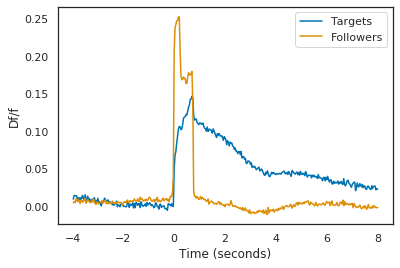

In [27]:
plt.plot(session.filter_ps_time, np.mean(targets, (0,1)), label='Targets')
plt.plot(session.filter_ps_time, np.mean(followers, (0,1)), label='Followers')

plt.legend()
plt.ylabel('Df/f')
plt.xlabel('Time (seconds)')

In [28]:
# Was a cell targeted on any trial?
ever_targeted = np.any(is_target, axis=(1,2))
# Check that all targets are in s1
for target, s1 in zip(ever_targeted, session.s1_bool):
    if target:
        assert s1
sum(ever_targeted)

123

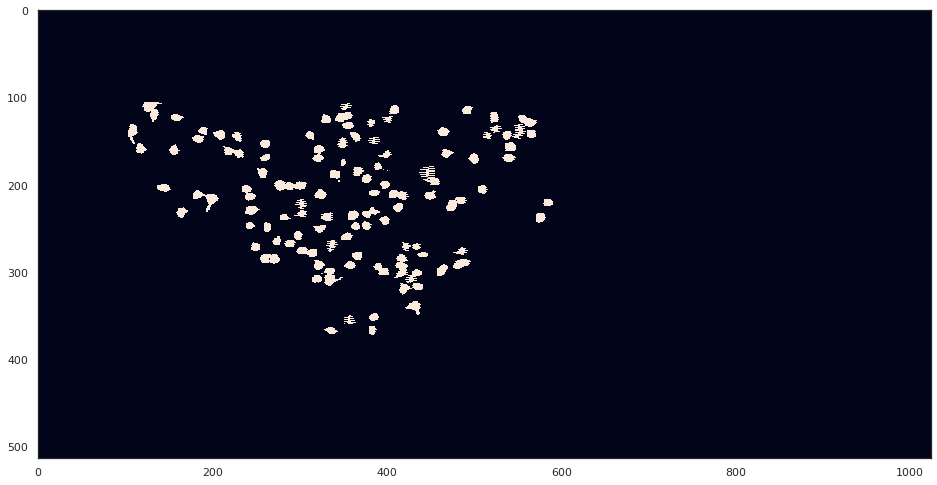

In [29]:
plt.figure(figsize=(16,16))
im = np.zeros((514,1024))
for coord in cell_coords[ever_targeted, :]:
    im[coord[0], coord[1]] = 1
plt.imshow(im)

In [299]:
tiff_path = os.path.expanduser('~/mnt/qnap/Data/2019-12-13/STA/2019-12-13_J064_t-001/'
          '2019-12-13_J064_t-001_15Stims_STA_dF_MaxResponseImage.tif')

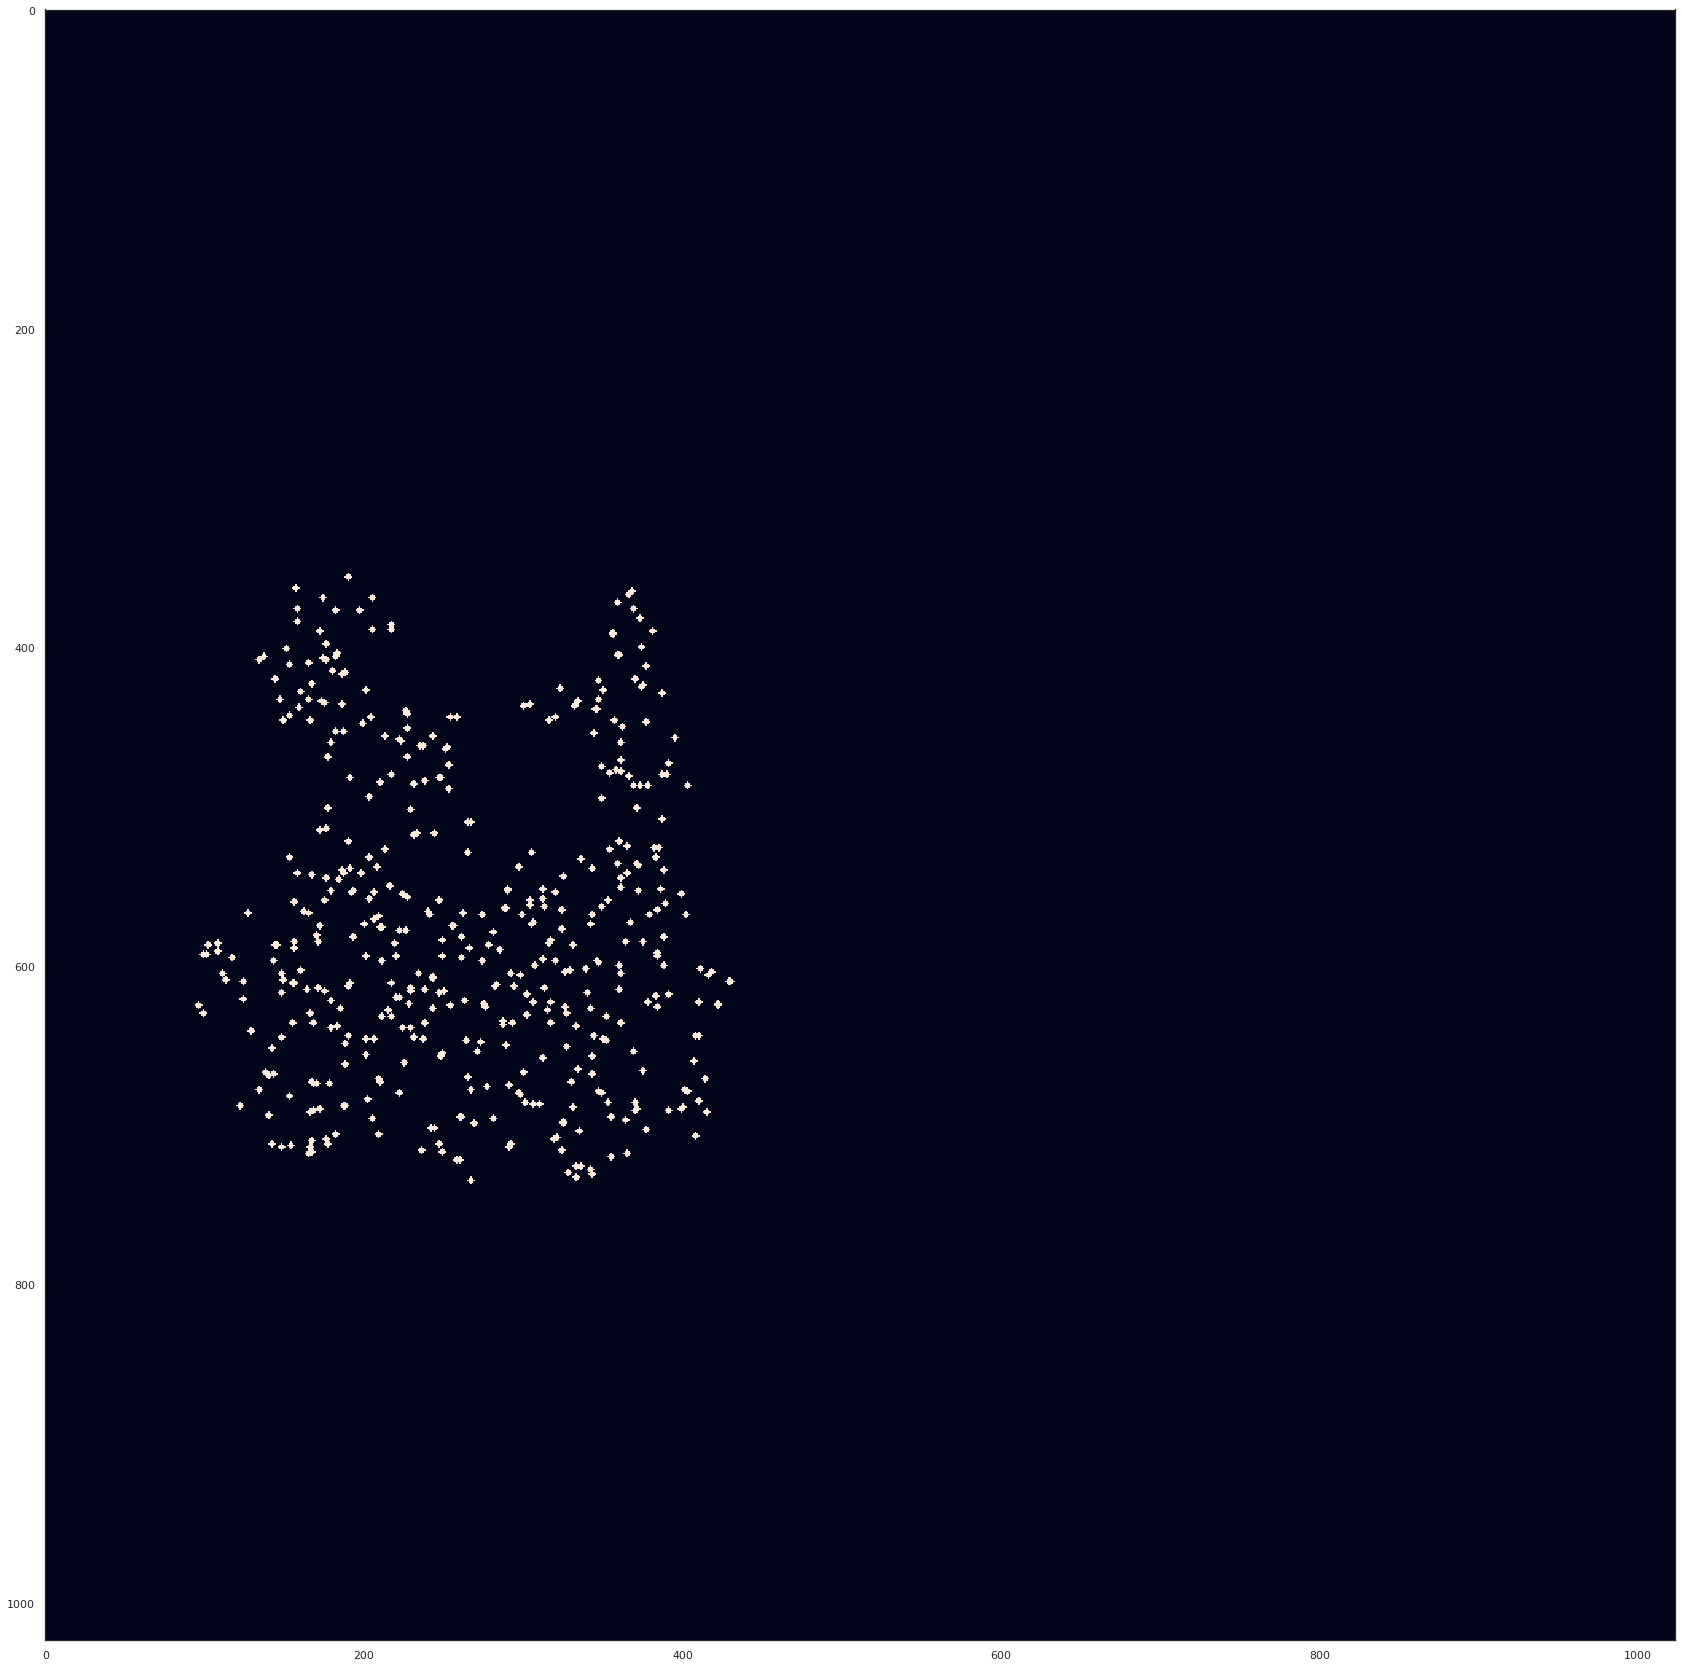

In [46]:
#tiff = tf.imread(tiff_path)
#tiff = tiff[256:513+257, :]
tiff = np.zeros((1024,1024))
tiff.shape

tiff[im.astype('bool')] = np.max(tiff)

y, x = np.where(im)

scale_x = 1
scale_y = 1
    
for xx, yy, in zip(x,y):
    tiff = cv2.circle(tiff, (int(scale_x*xx), int(scale_y*yy)) , radius=int(2), color=6000, thickness=-1)
    
plt.figure(figsize=(60,30))
plt.imshow(tiff)

In [282]:
is_target_og = copy.deepcopy(is_target)

In [283]:
from utils.run_functions import GetTargets
import time

In [284]:
gt = GetTargets(run)
is_target = gt.is_target[session.filtered_neurons, :]
is_target = is_target[:, session.nonnan_trials]
is_target = np.repeat(is_target[:, :, np.newaxis], session.n_times, axis=2)

In [285]:
is_target.shape

(2101, 130, 60)

In [286]:
(is_target == is_target_og).all()

False

In [287]:
# Was a cell targeted on any trial?
ever_targeted = np.any(is_target, axis=(1,2))
# Check that all targets are in s1
for target, s1 in zip(ever_targeted, session.s1_bool):
    if target:
        assert s1

In [288]:
sum(ever_targeted)

466

In [30]:
run.__dict__.keys()

dict_keys(['mouse_id', 'df', 'rows_2p', 'rows_1p', 'dates_2p', 'paqs', 'naparm_folders', 'blimp_folders', 'pycontrol_folders', 'prereward_folders', 'tseries_folders', 'plane_numbers', 'run_pycontrol_txt', 'num_planes', 'blimp_path', 'naparm_path', 'pycontrol_path', 'paq_path', 'prereward_path', 'tseries_paths', 'align_barcode', 'trial_info', 'session', 'print_lines', 'trial_time', 'outcome', 'slm_barcode', 'slm_trial_number', 'nogo_barcode', 'nogo_trial_number', 'alltrials_barcodes', 'rsync', 'trial_start', 'paq_rsync', 'frame_clock', 'x_galvo_uncaging', 'slm2packio', 'paq_rate', 'aligner', 'paq_correct', 'pre_rsync', 'pre_licks', 'pre_reward', 'prereward_aligner', 'both_aligner', 'num_frames', 's2p_path', 'flu_raw', 'frames_ms', 'frames_ms_pre', 'flu', 'spks', 'stat', 'paqio_frames', 'spiral_start', 'spiral_licks', 'autorewarded_trial', 'toosoon_idx', 'false_miss', 'denoised_flu'])

In [31]:
run.outcome

array(['miss', 'hit', 'fp', 'miss', 'hit', 'hit', 'miss', 'fp', 'hit',
       'cr', 'miss', 'hit', 'hit', 'cr', 'hit', 'hit', 'fp', 'cr', 'cr',
       'hit', 'hit', 'hit', 'hit', 'cr', 'hit', 'hit', 'hit', 'fp',
       'miss', 'fp', 'miss', 'cr', 'miss', 'hit', 'cr', 'hit', 'hit',
       'miss', 'hit', 'hit', 'fp', 'fp', 'cr', 'hit', 'fp', 'hit', 'fp',
       'cr', 'hit', 'miss', 'hit', 'hit', 'hit', 'hit', 'hit', 'fp',
       'hit', 'hit', 'hit', 'fp', 'hit', 'hit', 'cr', 'hit', 'fp', 'fp',
       'hit', 'fp', 'hit', 'hit', 'hit', 'hit', 'hit', 'hit', 'hit',
       'hit', 'fp', 'fp', 'hit', 'hit', 'hit', 'hit', 'fp', 'fp', 'hit',
       'hit', 'cr', 'fp', 'hit', 'fp', 'hit', 'cr', 'cr', 'hit', 'hit',
       'hit', 'hit', 'hit', 'fp', 'hit', 'hit', 'cr', 'hit', 'hit', 'fp',
       'fp', 'cr', 'miss', 'hit', 'hit', 'fp', 'hit', 'hit', 'fp', 'cr',
       'fp', 'hit', 'fp', 'miss', 'cr', 'cr', 'hit', 'hit', 'hit', 'cr',
       'cr', 'miss', 'cr', 'miss', 'cr', 'hit', 'hit', 'miss', 'hit',

## Plot to check coordinates are correct

In [109]:
# I think this is the non-transformed coordinates as the are also structure fields
# e.g. offset_x
x = mat['obj']['all_points']['X'] 
y = mat['obj']['all_points']['Y'] 


# x = mat['obj']['all_points']['X'] 
# y = mat['obj']['all_points']['Y'] 

In [ ]:
# naparm_path/Images has every image that was loaded in to naparm at the time, so will probably need manual
# inspection to 
tiff_file = '2019-08-03_J048_t-001_20Stims_STA_dF_MaxResponseImage.tif'

tiff_path = os.path.join(
                os.path.expanduser('/home/jrowland/mnt/qnap/Data/2019-08-03/STA/2019-08-03_J048_t-001'),
                tiff_file
                )

tiff = tf.imread(tiff_path)
tiff = tiff[::2, ::2]

tiff[y, x] = np.max(tiff)

plt.figure(figsize=(20,20,))
plt.imshow(tiff)
plt.colorbar()